In [32]:
# Train a new model
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import random
from scipy.special import softmax

# === CHAT'S CODE ====
# Basic configurable multi-head CNN
# Parameters:
# - input_channels: Number of channels in input images
# - num_classes: Number of output classes per head
# - heads_num: Number of classification heads
# - conv_layers_config: List of integers, number of filters per conv layer
# - avg_pool_spatial_size: Integer, number of spatial dimensions after average pooling
# - fc_layers_config: List of integers, number of neurons per fully connected layer IN EACH HEAD, NOT including linear classifier layer (last one)
# - dropout_prob: Dropout probability in FC layers
class MultiHeadCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, heads_num=3, conv_layers_config=[16, 32], avg_pool_spatial_size=1, fc_layers_config=[], dropout_prob=0.2):
        super(MultiHeadCNN, self).__init__()
        
        # Build convolutional backbone
        layers = []
        in_ch = input_channels
        for out_ch in conv_layers_config:
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_ch = out_ch
        layers.append(nn.AdaptiveAvgPool2d((avg_pool_spatial_size,avg_pool_spatial_size)))
        layers.append(nn.Flatten())
        self.features = nn.Sequential(*layers)
        
        # Flatten size after conv layers (assuming square input)
        self.flatten_size = in_ch * avg_pool_spatial_size * avg_pool_spatial_size  # placeholder, will compute dynamically in forward if needed
        
        # Build multi-heads
        self.classification_heads = nn.ModuleList()
        for _ in range(heads_num):
            head_layers = []
            prev_size = self.flatten_size
            for fc_size in fc_layers_config:
                head_layers.append(nn.Linear(prev_size, fc_size))
                head_layers.append(nn.ReLU())
                head_layers.append(nn.Dropout(dropout_prob))
                prev_size = fc_size
            head_layers.append(nn.Linear(prev_size, num_classes))
            self.classification_heads.append(nn.Sequential(*head_layers))
    
    def forward(self, x):
        # Convolutional backbone
        x = self.features(x)
        x = torch.flatten(x, 1)
        
        # Pass through each head
        outputs = []
        for head in self.classification_heads:
            outputs.append(head(x))
        return outputs

# A harder variation of MNIST with squiggles around the digit
class ClutteredMNIST(Dataset):
    def __init__(self, root="./data", train=True, download=True,
                 canvas_size=48, clutter_elements=8, clutter_size=None, transform=None):
        """
        canvas_size: output image size (square)
        clutter_elements: number of distractor patches per image
        clutter_size: size of the clutter patches (square)
        """
        self.mnist = datasets.MNIST(root, train=train, download=download)
        self.canvas_size = canvas_size
        self.clutter_elements = clutter_elements
        self.clutter_size = clutter_size
        self.digit_size = self.mnist[0][0].size[0]
        self.transform = transform

        if self.clutter_size is None:
            self.clutter_size = (self.canvas_size - self.digit_size) // 2

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, target = self.mnist[idx]
        img = np.array(img)

        # Create blank canvas
        canvas = np.zeros((self.canvas_size, self.canvas_size), dtype=np.uint8)


        # Place digit roughly in center
        digit_start = (self.canvas_size - self.digit_size) // 2
        digit_end = digit_start + self.digit_size
        canvas[digit_start:digit_end, digit_start:digit_end] = img

        # Add clutter patches
        center_count = 0
        center_max = 2
        for _ in range(self.clutter_elements):
            # pick random digit image
            rand_img, _ = self.mnist[random.randint(0, len(self.mnist)-1)]
            rand_img = np.array(rand_img)

            # crop a random patch
            x0 = random.randint(0, self.digit_size - self.clutter_size)
            y0 = random.randint(0, self.digit_size - self.clutter_size)
            patch = rand_img[y0:y0+self.clutter_size, x0:x0+self.clutter_size]

            # paste it at a random location on canvas
            if center_count >= center_max:
                cx = random.choice([random.randint(0, digit_start - self.clutter_size // 2),
                                    random.randint(digit_end - self.clutter_size // 2, self.canvas_size-self.clutter_size)])
                cy = random.choice([random.randint(0, digit_start - self.clutter_size // 2),
                                    random.randint(digit_end - self.clutter_size // 2, self.canvas_size-self.clutter_size)])
            else:
                cx = random.randint(0, self.canvas_size - self.clutter_size)
                cy = random.randint(0, self.canvas_size - self.clutter_size)
                c_middle_x = cx + self.clutter_size // 2
                c_middle_y = cy + self.clutter_size // 2
                if digit_start < c_middle_x < digit_end and digit_start < c_middle_y < digit_end:
                    center_count += 1
            canvas[cy:cy+self.clutter_size, cx:cx+self.clutter_size] = patch

        # Convert to tensor
        if self.transform:
            canvas = self.transform(canvas)

        return canvas, target

# Load dataset and split into train, val, test, and calibration sets.
def load_mnist(batch_size=64,
               train_size_p=0.65,
               val_size_p=0.1,
               test_size_p=0.1,
               cal_size_p=0.15,
               data_folder='./data',
               cluttered=True):

    torch.manual_seed(5)  # reproducibility

    # Transform for MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Download MNIST
    if not cluttered:
        train_set = datasets.MNIST(root=data_folder, train=True, download=True, transform=transform)
        test_set = datasets.MNIST(root=data_folder, train=False, download=True, transform=transform)
    else:
        train_set = ClutteredMNIST(train=True, transform=transform)
        test_set = ClutteredMNIST(train=False, transform=transform)

    # Combine train and test into one dataset for custom splitting
    dataset = ConcatDataset([train_set, test_set])

    # Compute split sizes
    num_samples = len(dataset)
    train_size = int(train_size_p * num_samples)
    val_size = int(val_size_p * num_samples)
    test_size = int(test_size_p * num_samples)
    cal_size = int(cal_size_p * num_samples)
    remaining_size = num_samples - (train_size + val_size + test_size + cal_size)

    # Split dataset
    train_set, val_set, test_set, cal_set, remaining_set = random_split(
        dataset, [train_size, val_size, test_size, cal_size, remaining_size]
    )

    # Merge leftover into train
    train_set = ConcatDataset([train_set, remaining_set])

    # Create loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
    cal_loader = DataLoader(cal_set, batch_size=batch_size, shuffle=False, num_workers=1)

    return train_loader, val_loader, test_loader, cal_loader

def evaluate_individual_heads(model, data_loader, criterion, device, heads_num=7):
    model.eval()
    running_losses = np.zeros(heads_num)
    corrects = [0] * heads_num
    results=[]
    count=-1
    targets=[]
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            all_outputs = model(data)
            for i, outputs in enumerate(all_outputs):
                loss = criterion(outputs, target.long())
                running_losses[i] += loss.item()
                _, predicted = outputs.max(1)
                corrects[i] += predicted.eq(target).sum().item()
                if count == -1:
                    results.append(outputs.cpu().numpy())
                else:
                    results[i] = np.concatenate([results[i], outputs.cpu().numpy()], axis=0)
            count = 0
            targets = np.concatenate([targets, target.cpu().numpy()], axis=0)

    losses =  np.array(running_losses) / len(data_loader)
    accuracies = (np.array(corrects)/results[0].shape[0]).tolist()
    return losses, accuracies,np.array(results),targets

if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    heads_num = 7 # Number of heads to train

    train_loader, val_loader, test_loader, cal_loader = load_mnist(batch_size=batch_size, val_size_p=0.0, cluttered=True)
    model = MultiHeadCNN(input_channels=1,
                         num_classes=10,
                         heads_num=heads_num,
                         conv_layers_config=[16, 32, 64],
                         avg_pool_spatial_size=2,
                         fc_layers_config=[64],
                         dropout_prob=0.2).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(50):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)  # list of [batch, num_classes]
            
            # Average loss over all heads
            loss = sum(criterion(out, target) for out in outputs) / len(outputs)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f"Train Epoch {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}] "
                    f"Loss: {loss.item():.4f}")

        # Test
        model.eval()
        test_loss = 0
        correct = [0]*len(model.classification_heads)
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                
                test_loss += data.shape[0] * sum(criterion(out, target) for out in outputs) / len(outputs)
                for i, out in enumerate(outputs):
                    #test_loss += criterion(out, target).item()
                    pred = out.argmax(dim=1)
                    correct[i] += pred.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        accs = [100. * c / len(test_loader.dataset) for c in correct]
        print(f"\nTest set: Avg loss: {test_loss:.4f}")
        for i, acc in enumerate(accs):
            print(f" Head {i}: Accuracy: {acc:.2f}%")
        print()

# Save outputs
test_loss, test_accuracy,test_output,test_targets = evaluate_individual_heads(model, test_loader, criterion, device)
cal_loss, cal_accuracy,cal_output,cal_targets = evaluate_individual_heads(model, cal_loader, criterion, device)
save_dir = 'outputs'
dataset_name = 'ClutteredMNIST'
np.save(f"{save_dir}/test_outputs_{dataset_name}.npy", softmax(test_output,axis=2))
np.save(f"{save_dir}/cal_outputs_{dataset_name}.npy", softmax(cal_output,axis=2))
np.save(f"{save_dir}/cal_target_{dataset_name}.npy", cal_targets)
np.save(f"{save_dir}/test_target_{dataset_name}.npy", test_targets)

Train Epoch 0 [0/52500] Loss: 2.3022
Train Epoch 0 [6400/52500] Loss: 2.3050
Train Epoch 0 [12800/52500] Loss: 2.3077
Train Epoch 0 [19200/52500] Loss: 2.2980
Train Epoch 0 [25600/52500] Loss: 2.3033
Train Epoch 0 [32000/52500] Loss: 2.2969
Train Epoch 0 [38400/52500] Loss: 2.3003
Train Epoch 0 [44800/52500] Loss: 2.3050
Train Epoch 0 [51200/52500] Loss: 2.3032

Test set: Avg loss: 2.3032
 Head 0: Accuracy: 11.50%
 Head 1: Accuracy: 12.16%
 Head 2: Accuracy: 10.31%
 Head 3: Accuracy: 11.16%
 Head 4: Accuracy: 9.46%
 Head 5: Accuracy: 10.27%
 Head 6: Accuracy: 11.50%

Train Epoch 1 [0/52500] Loss: 2.3021
Train Epoch 1 [6400/52500] Loss: 2.3038
Train Epoch 1 [12800/52500] Loss: 2.3030
Train Epoch 1 [19200/52500] Loss: 2.3063
Train Epoch 1 [25600/52500] Loss: 2.2991
Train Epoch 1 [32000/52500] Loss: 2.2993
Train Epoch 1 [38400/52500] Loss: 2.3010
Train Epoch 1 [44800/52500] Loss: 2.3075
Train Epoch 1 [51200/52500] Loss: 2.3085

Test set: Avg loss: 2.3023
 Head 0: Accuracy: 11.50%
 Head 1:

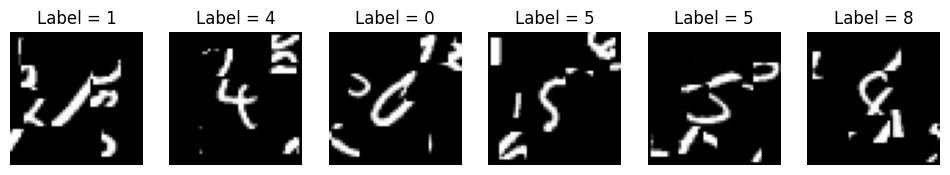

In [31]:
import matplotlib.pyplot as plt

# Get one batch
images, labels = next(iter(train_loader))

# Plot first 6
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(images[i][0], cmap='gray')
    axes[i].set_title(f'Label = {labels[i].item()}')
    axes[i].axis("off")
plt.show()

In [ ]:
from utils import load_data, compute_scores, generate_Dcal_Dcells_sets, create_random_split
from multi_dim_cp import main_algo
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.spatial import cKDTree
from matplotlib.patches import Patch
from utils import create_true_rest_sets
from tabulate import tabulate

np.random.seed(5)

config={
    'DATASET_NAME': 'PathMNIST_demo', # CIFAR100_demo, PathMNIST_demo
    
    'ALPHA': 0.2,
    
    'b': 1, # Always 1
    
    'N_HEADS': [1,2,4,7],
    
    'SCORING_METHOD': 'RAPS' # RAPS, SAPS , NAIVE , APS
    
}

cal_output,cal_target,test_output,test_target=load_data(config)
